# Project Idea
This project is to build a binomial logistic regression model to help Waze's Operations Management to drive consequential business decisions.
    
This activity has three parts:
- Part 1: EDA & Checking Model Assumptions
- Part 2: Model Building and Evaluation
- Part 3: Interpreting Model Results

# Build a Regression Model

### Task 1. Imports and Data Loading

In [1]:
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Logistic Regression & Confusion Matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/adacert/waze/main/Synthetic_Waze_Data_14999%20-%20Fictional_Waze_Data_14999.csv')

### Task 2a. Explore Data

In [3]:
# Explore some info about the data
print(df.shape)
df.info()

(14999, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [4]:
# Display few records of the data
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


**Insight**
Use the `drop()` method to remove the `ID` column since we don't need this information for analysis.

In [5]:
# Use this approach
df.drop('ID', axis=1)

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
...,...,...,...,...,...,...,...,...,...,...,...,...
14994,retained,60,55,207.875622,140,317,0,2890.496901,2186.155708,25,17,iPhone
14995,retained,42,35,187.670313,2505,15,10,4062.575194,1208.583193,25,20,Android
14996,retained,273,219,422.017241,1873,17,0,3097.825028,1031.278706,18,17,iPhone
14997,churned,149,120,180.524184,3150,45,0,4051.758549,254.187763,6,6,iPhone


In [6]:
# Check the class balance of the dependent (target) variable, `label`.
df['label'].value_counts(normalize=True)

retained    0.822645
churned     0.177355
Name: label, dtype: float64

**Insight**
Because the target class is imbalanced (82% retained vs. 18% churned), we want to make sure that we don't get an unlucky split that over/under represents the frequency of the minority class. This is done in two ways: 
- Upsample the minority class at this point or 
- Use the function's `stratify` parameter to target `y` to ensure that the minority class appears in both train and test sets in the same proportion that it does in the overall dataset when spliting the data into training and testing.

In [7]:
# Display simple statistics about the data
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,7499.000000,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,4329.982679,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,7499.000000,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,11248.500000,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,14998.000000,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


**Insight** 
Just by assessing at the quartile values, standard deviation, and max values, the following features all seem to potentially have outliers. All of these features have max values that are multiple standard deviations above the 75th percentile.
        
- `sessions`
- `drives`
- `total_sessions`
- `total_navigations_fav1`
- `total_navigations_fav2`
- `driven_km_drives`
- `duration_minutes_drives`

### Task 2b. Feature Engineering

#### Creat `km_per_driving_day` Feature
Create a new feature called `km_per_driving_day`, which represents the mean distance driven per driving day for each user.

In [8]:
# Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# Call `describe()` on the new feature
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

**Insight**
It seems that some values of zero in the `driving_days` column, which yield in the values of infinite (inf) in the `km_per_driving_day` because division by zero is undefined.

In [9]:
# Convert infinite values to zero
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0

# Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### Create `professional_driver` Feature
- To separate professional drivers from other drivers.Create a new, a binary feature called `professional_driver` that is a 1 for users who had 100 or more drives and drove on 15+ days in the last month, and 0 otherwise is extracted.

In [10]:
# Create `professional_driver` feature using the `np.where()` method
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [11]:
# Perform a quick inspection of the professional_driver feature by:

# 1. Checking the count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# 2. Calculating the churn rate within each class (professional and non-professional)
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

0    12405
1     2594
Name: professional_driver, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: label, dtype: float64

**Insight**
The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

## Building Model

### Task 3a. Preparing Variables

In [12]:
# Check the missing values of the outcome feature `label` 
df['label'].isna().sum()

# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

#### **Impute Outliers**
Sometimes outliers can be changed to the median, mean, 95th percentile, etc. The following seven features all had clear signs of containing outliers:

- `sessions`
- `drives`
- `total_sessions`
- `total_navigations_fav1`
- `total_navigations_fav2`
- `driven_km_drives`
- `duration_minutes_drives`

For this analysis, impute the outlying values for these features and replace them with the 95th percentile of each feature.

In [13]:
# Impute outliers
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

In [14]:
# Display a few statistics again to make sure no more outliers
df.describe()

,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,7503.573117,76.539688,63.964683,183.717304,1751.822505,114.562767,27.187216,3944.558631,1792.911210,15.544653,12.182530,581.942399,0.173998
std,4331.207621,67.243178,55.127927,118.720520,1008.663834,124.378550,36.715302,2218.358258,1224.329759,9.016088,7.833835,1038.254509,0.379121
min,0.000000,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000
25%,3749.500000,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000
50%,7504.000000,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000
75%,11257.500000,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000
max,14998.000000,243.000000,200.000000,455.439492,3500.000000,422.000000,124.000000,8898.716275,4668.180092,31.000000,30.000000,15420.234110,1.000000


#### **Encode Categorical Features**
- Change the data type of the outcome feature `label` to be binary: `0` for all `retained` users and `1` for all `churned` users.
- Change the data type of the predictor feature `device` to be binary: `0` for all `Android` and `1` for all `iPhone`

In [15]:
# Create another outcome variable `label2` as to not overwrite the original `label` variable.
df['label2'] = np.where(df['label'] == 'retained', 0, 1)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


In [16]:
# Create another outcome variable `device2` as to not overwrite the original `device` variable.
df['device2'] = np.where(df['device'] == 'Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


### **Task 3b. Checking Assumptions for Logistic Regression Model**
1. Independent observations (This refers to how the data was collected.)
2. No extreme outliers (This has already fixed previously)
3. Little to no multicollinearity among X predictors
4. Linear relationship between X and the **logit** of y

#### **Third Assumption: Collinearity**

In [17]:
# Generate a correlation matrix
df.corr(method='pearson')

C:\Users\Asaad\AppData\Local\Temp\ipykernel_10860\3629950414.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method='pearson')


,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2,device2
ID,1.000000,0.011611,0.010749,0.005552,-0.005300,0.000606,-0.003195,0.000466,0.001909,-0.000891,-0.000981,-0.005151,0.012436,0.004425,-0.012653
sessions,0.011611,1.000000,0.996942,0.597189,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911,0.012704
drives,0.010749,0.996942,1.000000,0.595285,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865,0.011684
total_sessions,0.005552,0.597189,0.595285,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254433,0.024568,0.012138
n_days_after_onboarding,-0.005300,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263,-0.011299
total_navigations_fav1,0.000606,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322,-0.001316
total_navigations_fav2,-0.003195,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032,-0.000275
driven_km_drives,0.000466,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690515,-0.007441,-0.009549,0.344811,-0.000904,0.019767,-0.002091
duration_minutes_drives,0.001909,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690515,1.000000,-0.007895,-0.009425,0.239627,-0.012128,0.040407,-0.007709
activity_days,-0.000891,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851,-0.010221


C:\Users\Asaad\AppData\Local\Temp\ipykernel_10860\3224828558.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')


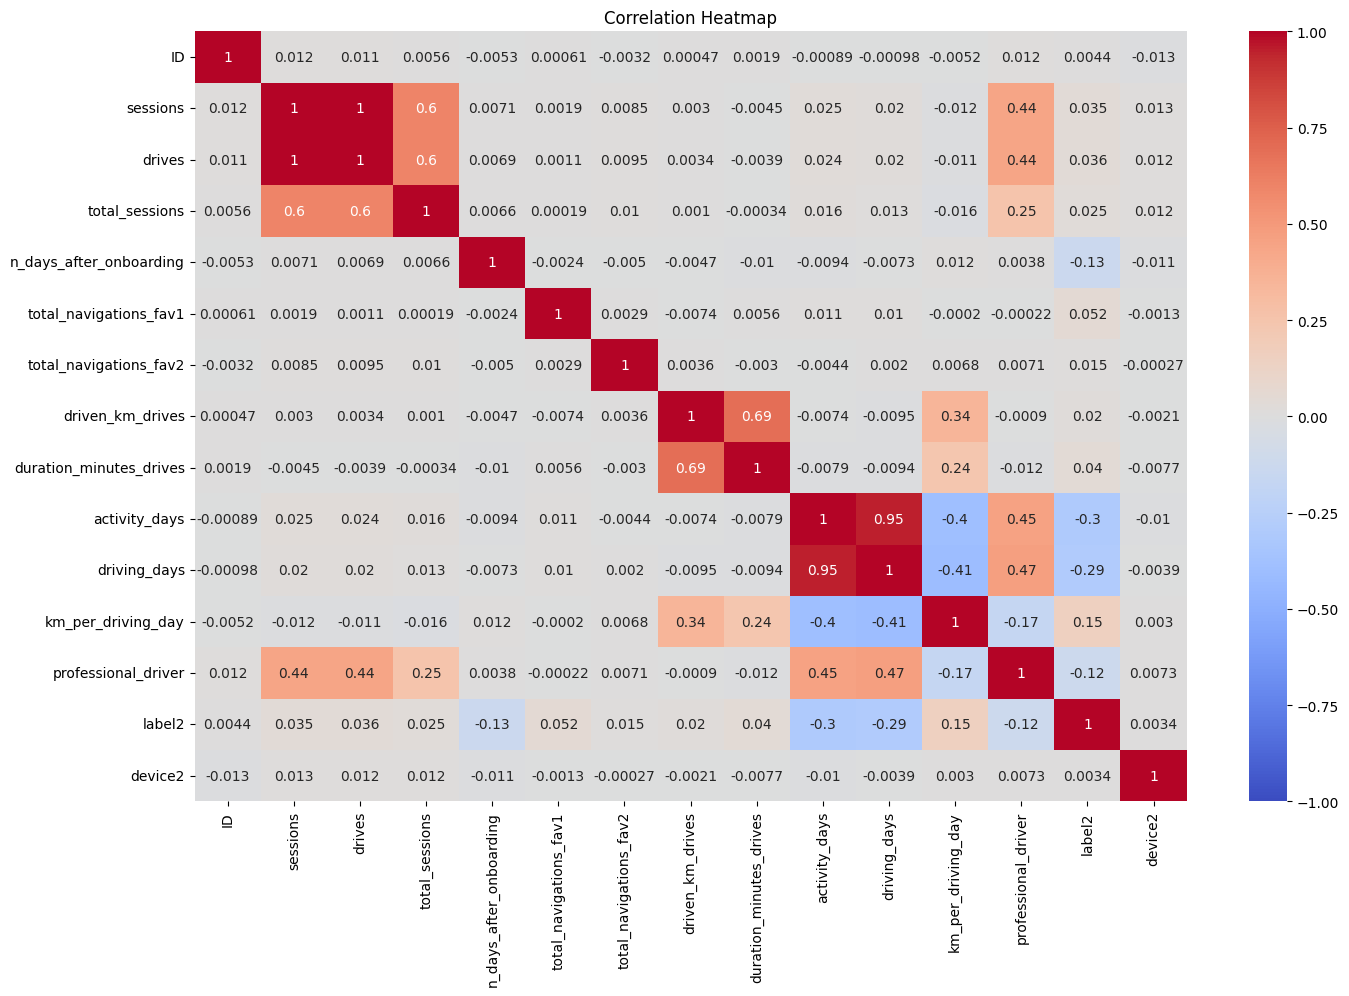

In [19]:
# Plot correlation heatmap
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=12)
plt.show()

**Insight**
The following X predictors are strongly multicollinear as they have a Pearson correlation coefficient value greater than the **absolute value of 0.7**.
- `sessions` and `drives` have a Pearson correlation coefficient value of 1.0
- `driving_days` and `activity_days` have a Pearson correlation coefficient value of 0.95

**Note:** 0.7 is an arbitrary threshold. Some industries may use 0.6, 0.8, etc.

### **Task 3d. Building Model**

#### **Determine X Predictors and Target y**
The `sessions` and `driving_days` were selected to be dropped, rather than `drives` and `activity_days` because the features that were kept for modeling had slightly stronger correlations with the target variable than the features that were dropped, according to the correlation matrix and heatmap.

In [20]:
# Determine the X predictors
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [21]:
# Determine the y target feature
y = df['label2']

#### **Split the Data**
Since the target class is imbalanced (82% retained vs. 18% churned), set the function's `stratify` parameter to `y` to ensure that the minority class appears in both train and test sets in the same proportion that it does in the overall dataset.

In [22]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [23]:
# Use .head()
X_train.head()

,ID,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
152,152,108,186.192746,3116,243,124,8898.716275,4668.180092,24,612.305861,1,1
11899,11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,1
10937,10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,0
669,669,108,455.439492,2320,11,4,6566.424830,4558.459870,18,410.401552,1,1
8406,8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,1


In [24]:
# Instantiate a logistic regression model, and add the argument `penalty = None` since X predictors are unscaled
model = LogisticRegression(penalty='none', max_iter=400)

# Fit the model on X_train and y_train.
model.fit(X_train, y_train)

c:\Users\Asaad\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


LogisticRegression(max_iter=400, penalty='none')

In [25]:
# Call the `.coef_` attribute on the model to get the coefficients of each variable.
# The coefficients represent the change in the **log odds** of the target variable for every one unit increase in X.
pd.Series(model.coef_[0], index=X.columns)

ID                         0.000003
drives                     0.001903
total_sessions             0.000311
n_days_after_onboarding   -0.000409
total_navigations_fav1     0.001221
total_navigations_fav2     0.000902
driven_km_drives          -0.000016
duration_minutes_drives    0.000109
activity_days             -0.106348
km_per_driving_day         0.000018
professional_driver       -0.001603
device2                   -0.000884
dtype: float64

In [26]:
# Call the model's `intercept_` attribute to get the intercept of the model.
model.intercept_

array([-0.0014446])

#### **Forth Assumption: Linear relationship between X and the estimated log odds (known as logits)**
Call the model's `predict_proba()` method to generate the probability of response for each sample in the training data

In [27]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)

# The results in `training_probabilities` in a 2-D array where each row represents a user in `X_train`:
# The first column is the probability of the user not churning, and the second column is the probability of the user churning.
training_probabilities

array([[0.94170299, 0.05829701],
       [0.61472909, 0.38527091],
       [0.7632596 , 0.2367404 ],
       ...,
       [0.92038649, 0.07961351],
       [0.85293123, 0.14706877],
       [0.93501002, 0.06498998]])

**Rule**
In **logistic regression**, the relationship between a predictor variable and the dependent variable does not need to be linear, however, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. Here is the formula for calculating log-odds, where _p_ is the probability of response:
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$
<br>

In [28]:
# Copy the `X_train` dataframe and assign to a new dataFrame called `logit_data`
logit_data = X_train.copy()

# Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

Text(0.5, 1.0, 'Log-odds: activity_days')

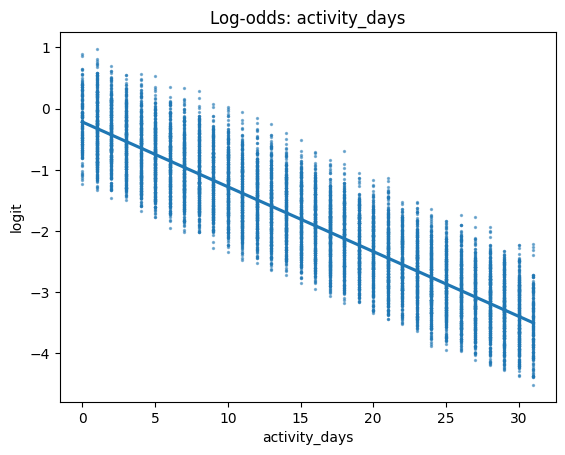

In [29]:
# Plot regplot of `activity_days` log-odds; We can do the same for any other contineous or discrete variable
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days')

### **Task 4a. Results and Evaluation**

In [30]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

In [31]:
# Use the `score()` method on the model with `X_test` and `y_test` as its two arguments. The default score in scikit-learn is **accuracy**.
model.score(X_test, y_test)

0.8237762237762237

### **Task 4b. Display results with a Confusion Matrix**

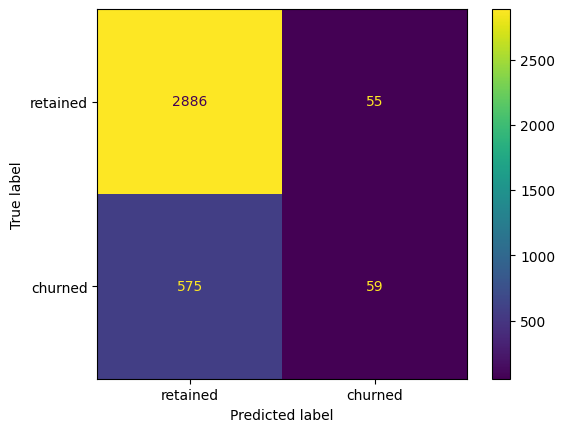

In [32]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_preds)

# Create a display for the confusion matrix `cm`
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])
disp.plot()

In [33]:
# Calculate precision
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
print('precision = ', precision)

# Calculate recall
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
print('recall', recall)

precision =  0.5175438596491229
recall 0.09305993690851735


In [34]:
# Create a classification report from the scikit-learn's [`classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.52      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



**Insight** 
- The model has mediocre _precision_ and very low _recall_, which means that it makes a lot of false negative predictions and fails to capture users who will churn.
- Below is to visualize the model's coefficients to show the importance of the model's features.

In [35]:
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

[('drives', 0.0019028637733657953),
 ('total_navigations_fav1', 0.0012208361504791889),
 ('total_navigations_fav2', 0.000902469778512293),
 ('total_sessions', 0.0003111877120461242),
 ('duration_minutes_drives', 0.00010860110778771036),
 ('km_per_driving_day', 1.7790412266883105e-05),
 ('ID', 2.662051609211516e-06),
 ('driven_km_drives', -1.5874465501541028e-05),
 ('n_days_after_onboarding', -0.00040914122529041324),
 ('device2', -0.0008844956682553199),
 ('professional_driver', -0.0016029448090754737),
 ('activity_days', -0.10634781895244293)]

Text(0.5, 1.0, 'Feature importance')

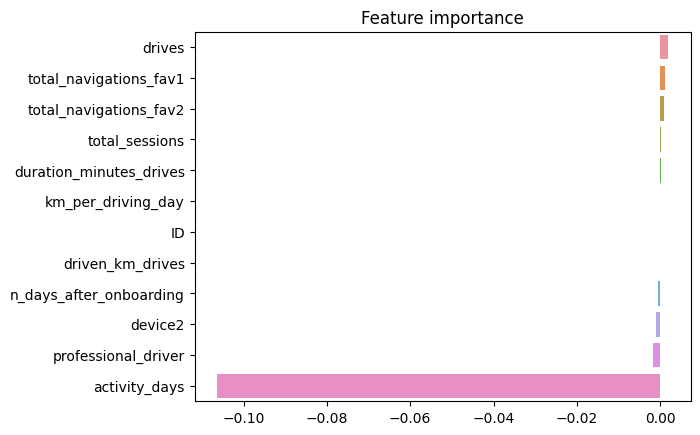

In [36]:
# Plot the feature importances
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance')

### **Task 4c. Executive Summary**

> _`activity_days` was by far the most important feature in the model. It has a negative correlation with user churn. This was not surprising, as this variable was very strongly correlated with `driving_days`, which was known from EDA to have a negative correlation with churn._

> The correlation heatmap revealed the `km_per_driving_day` variable to have the strongest positive correlation with churn of any of the predictor variables by a relatively large margin. It was the second-least-important variable.

> _New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, one of the engineered features (`professional_driver`) was the third-most-predictive predictor. It could also be helpful to scale the predictor variables, and/or to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._